In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.image import DirectoryIterator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import cv2
from tensorflow.keras.utils import Sequence


# === STEP 1: Load dataset info (file names, labels) ===
def get_image_info(base_dir):
    all_data = []
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(base_dir, split)
        for class_name in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, class_name)
            if os.path.isdir(class_dir):
                for img_file in os.listdir(class_dir):
                    if img_file.lower().endswith(('jpg', 'jpeg', 'png')):
                        all_data.append([split, class_name, os.path.join(class_dir, img_file)])
    return pd.DataFrame(all_data, columns=["split", "label", "filepath"])

df = get_image_info("/mnt/c/Users/muham/Documents/Documents/Tugas Kuliah/Tugas Kuliah Semester 6/Deep-Learning/Week 8 (UTS)/FishImgDataset")
print(df.head())

   split   label                                           filepath
0  train  Bangus  /mnt/c/Users/muham/Documents/Documents/Tugas K...
1  train  Bangus  /mnt/c/Users/muham/Documents/Documents/Tugas K...
2  train  Bangus  /mnt/c/Users/muham/Documents/Documents/Tugas K...
3  train  Bangus  /mnt/c/Users/muham/Documents/Documents/Tugas K...
4  train  Bangus  /mnt/c/Users/muham/Documents/Documents/Tugas K...


In [14]:
# Bersihkan label
df['label'] = df['label'].str.strip().str.lower()

# Label encoding
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# One-hot encoding
one_hot = pd.get_dummies(df['label'])
df = pd.concat([df, one_hot], axis=1)

In [15]:
target_size = (150, 150)
batch_size = 64

def resize_with_padding(img, target_size=(150, 150)):
    old_size = img.shape[:2]  # (height, width)
    ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])
    new_size = tuple([int(x * ratio) for x in old_size[::-1]])

    resized = cv2.resize(img, new_size)

    delta_w = target_size[1] - new_size[0]
    delta_h = target_size[0] - new_size[1]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_img

class CustomDirectoryIterator(DirectoryIterator):
    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=self.dtype)
        for i, j in enumerate(index_array):
            fname = self.filepaths[j]
            img = cv2.imread(fname)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = resize_with_padding(img, self.target_size)
            img = img.astype(self.dtype) / 255.0
            batch_x[i] = img

        # Apply labels
        if self.class_mode == 'categorical':
            batch_y = np.zeros((len(batch_x), len(self.class_indices)), dtype=self.dtype)
            for i, label in enumerate(self.classes[index_array]):
                batch_y[i, label] = 1.
        else:
            batch_y = self.classes[index_array]

        return batch_x, batch_y

train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1
)

train_generator = CustomDirectoryIterator(
    directory="/mnt/c/Users/muham/Documents/Documents/Tugas Kuliah/Tugas Kuliah Semester 6/Deep-Learning/Week 8 (UTS)/FishImgDataset/train",
    image_data_generator=train_datagen,
    target_size=target_size,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_generator = CustomDirectoryIterator(
    directory="/mnt/c/Users/muham/Documents/Documents/Tugas Kuliah/Tugas Kuliah Semester 6/Deep-Learning/Week 8 (UTS)/FishImgDataset/val",
    image_data_generator=ImageDataGenerator(),
    target_size=target_size,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

test_generator = CustomDirectoryIterator(
    directory="/mnt/c/Users/muham/Documents/Documents/Tugas Kuliah/Tugas Kuliah Semester 6/Deep-Learning/Week 8 (UTS)/FishImgDataset/test",
    image_data_generator=ImageDataGenerator(),
    target_size=target_size,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3) ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    batch_size=128,
    verbose=1
)

/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1745926088.862223   22466 service.cc:148] XLA service 0x7f775400ffe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745926088.862413   22466 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-04-29 18:28:08.994230: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745926089.633297   22466 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-29 18:28:11.711296: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,64,148,148]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,150,150]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"act

  1/138 ━━━━━━━━━━━━━━━━━━━━ 37:32 16s/step - accuracy: 0.0000e+00 - loss: 3.4361

I0000 00:00:1745926100.336136   22466 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 26/138 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - accuracy: 0.1076 - loss: 3.3706

2025-04-29 18:29:07.918103: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[33,64,148,148]{3,2,1,0}, u8[0]{0}) custom-call(f32[33,3,150,150]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-29 18:29:08.064176: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[33,64,72,72]{3,2,1,0}, u8[0]{0}) custom-call(f32[33,64,74,74]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1350 - loss: 3.2984

2025-04-29 18:32:52.077628: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,64,148,148]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,150,150]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-29 18:32:52.308929: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,64,72,72]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,74,74]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

138/138 ━━━━━━━━━━━━━━━━━━━━ 360s 3s/step - accuracy: 0.1351 - loss: 3.2978 - val_accuracy: 0.2025 - val_loss: 2.9127
Epoch 2/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.2113 - loss: 2.8562 - val_accuracy: 0.2959 - val_loss: 2.5168
Epoch 3/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.2846 - loss: 2.4917 - val_accuracy: 0.3828 - val_loss: 2.1291
Epoch 4/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.3762 - loss: 2.1846 - val_accuracy: 0.4696 - val_loss: 1.8153
Epoch 5/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.4613 - loss: 1.8395 - val_accuracy: 0.5409 - val_loss: 1.5429
Epoch 6/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.5095 - loss: 1.6554 - val_accuracy: 0.5918 - val_loss: 1.4175
Epoch 7/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.5685 - loss: 1.4561 - val_accuracy: 0.6870 - val_loss: 1.0806
Epoch 8/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.6326 - loss: 1.2273 - val_accuracy: 0.708

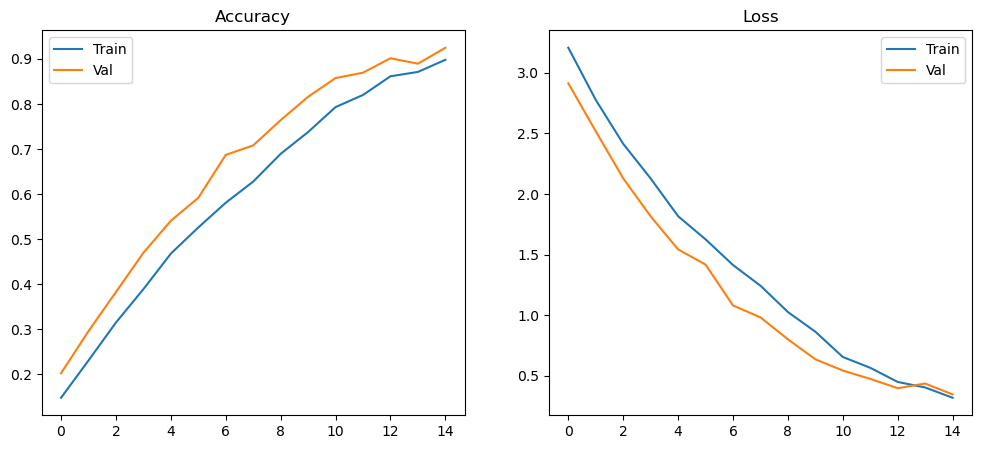

In [18]:
def plot_train_val(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_train_val(history)

2025-04-29 19:41:35.877283: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,32,34,34]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,36,36]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-29 19:41:35.961705: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,32,15,15]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,17,17]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"

1760/1760 ━━━━━━━━━━━━━━━━━━━━ 77s 43ms/step
Accuracy: 0.8852
Precision: 0.8900
Recall: 0.8852
F1-Score: 0.8859


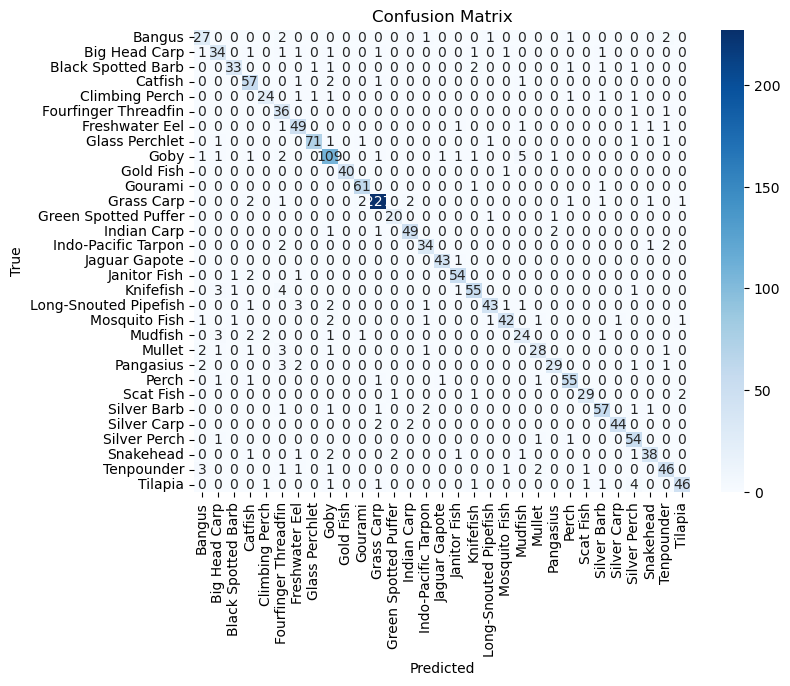

                       precision    recall  f1-score   support

               Bangus       0.73      0.79      0.76        34
        Big Head Carp       0.76      0.79      0.77        43
   Black Spotted Barb       0.92      0.82      0.87        40
              Catfish       0.83      0.92      0.87        62
       Climbing Perch       0.89      0.80      0.84        30
 Fourfinger Threadfin       0.63      0.95      0.76        38
       Freshwater Eel       0.82      0.89      0.85        55
       Glass Perchlet       0.97      0.92      0.95        77
                 Goby       0.86      0.88      0.87       124
            Gold Fish       1.00      0.98      0.99        41
              Gourami       0.94      0.97      0.95        63
           Grass Carp       0.96      0.95      0.96       238
 Green Spotted Puffer       0.87      0.91      0.89        22
          Indian Carp       0.92      0.92      0.92        53
  Indo-Pacific Tarpon       0.85      0.87      0.86  

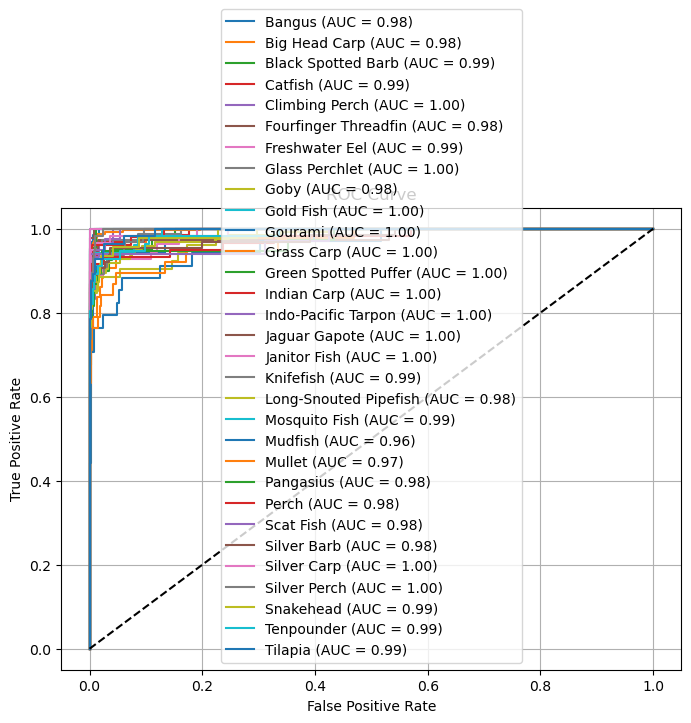

In [19]:
# Predict
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# AUC-ROC (One-vs-Rest)
y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=len(test_generator.class_indices))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(test_generator.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC
plt.figure(figsize=(8,6))
for i, label in enumerate(test_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f"{label} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()